<a href="https://colab.research.google.com/github/Kritikargv17/Deep-Learning-LAB/blob/main/Exp13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Loading Fashion-MNIST dataset...
Train images shape: torch.Size([60000, 1, 28, 28])
Test images shape: torch.Size([10000, 1, 28, 28])

Starting training...
Epoch 1 [0/60000] Loss: 624.2992 Recon: 624.2944 KL: 0.0048
Epoch 1 [12800/60000] Loss: 327.5128 Recon: 316.0888 KL: 11.4241
Epoch 1 [25600/60000] Loss: 291.6725 Recon: 282.8002 KL: 8.8723
Epoch 1 [38400/60000] Loss: 299.5927 Recon: 293.1367 KL: 6.4560
Epoch 1 [51200/60000] Loss: 268.3636 Recon: 261.0925 KL: 7.2712
====> Epoch 1: Train loss: 323.1194, Test loss: 288.1052
Epoch 2 [0/60000] Loss: 290.9529 Recon: 284.3125 KL: 6.6404
Epoch 2 [12800/60000] Loss: 268.0041 Recon: 261.1120 KL: 6.8921
Epoch 2 [25600/60000] Loss: 281.6221 Recon: 275.4206 KL: 6.2015
Epoch 2 [38400/60000] Loss: 291.0583 Recon: 284.7567 KL: 6.3016
Epoch 2 [51200/60000] Loss: 279.5877 Recon: 273.3390 KL: 6.2488
====> Epoch 2: Train loss: 282.4095, Test loss: 280.2651
Epoch 3 [0/60000] Loss: 277.9379 Recon: 271.7216 KL: 6.2163
Epoch 3 [12800/6000

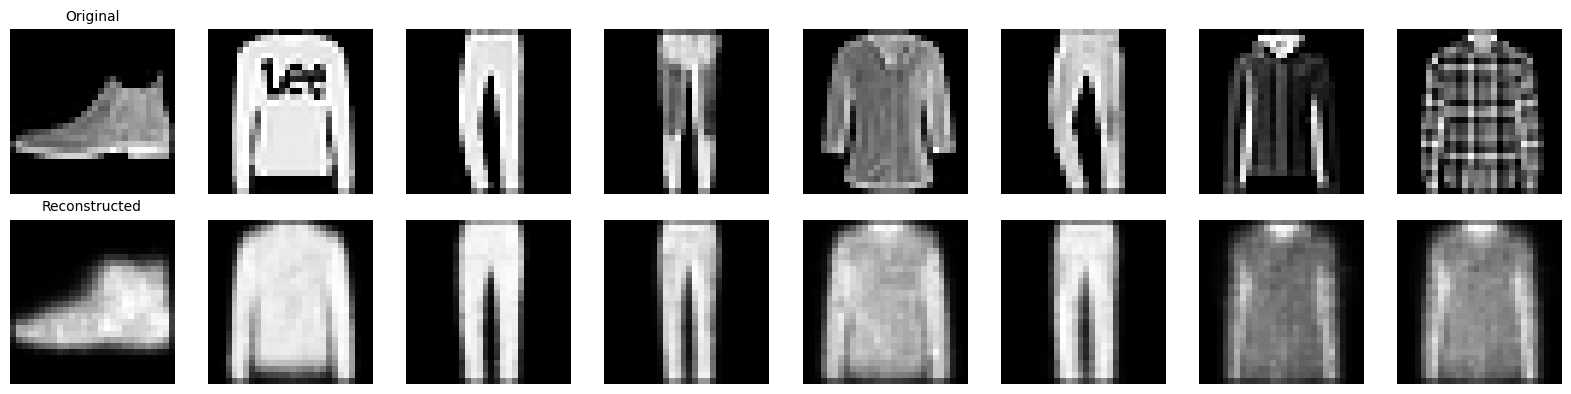


2. Visualizing latent space...
   ✓ Saved: vae_latent_space.png


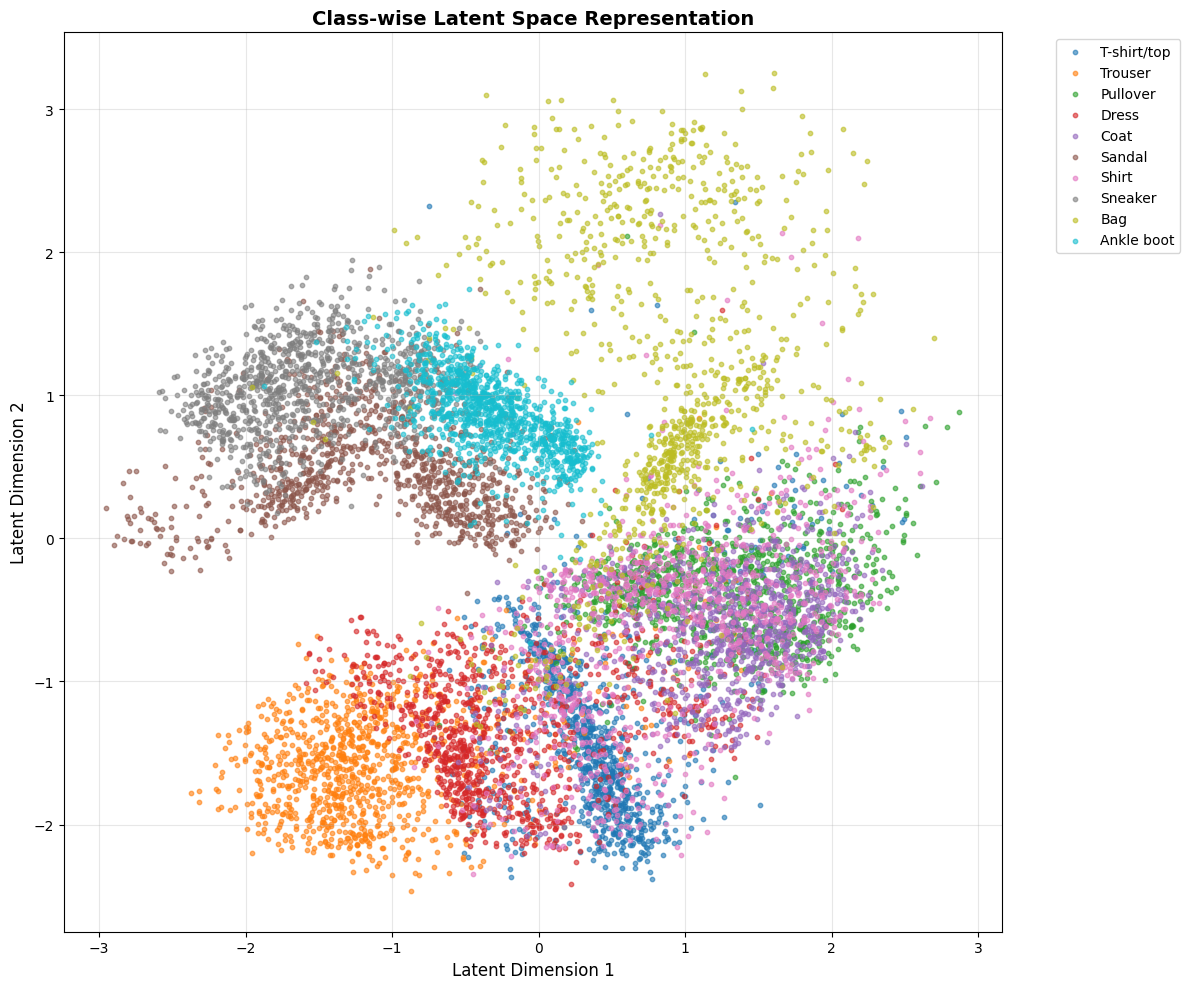


3. Generating novel images...
   ✓ Saved: vae_generated_samples.png


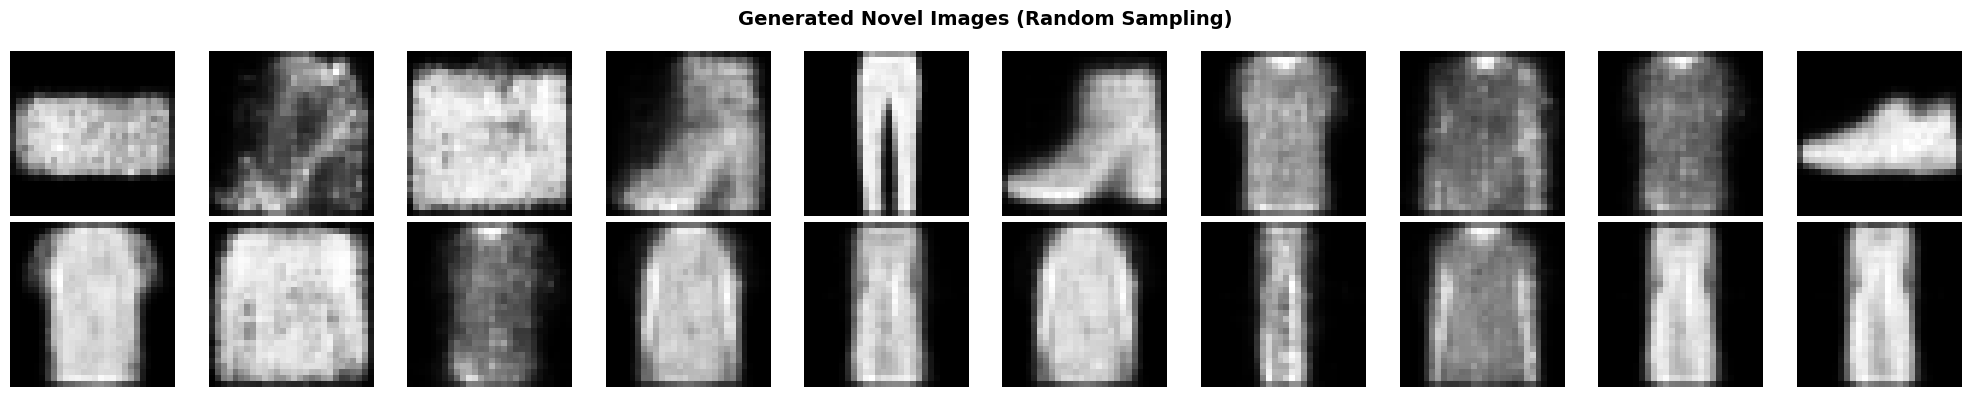


4. Generating latent space interpolation...
   ✓ Saved: vae_interpolation.png


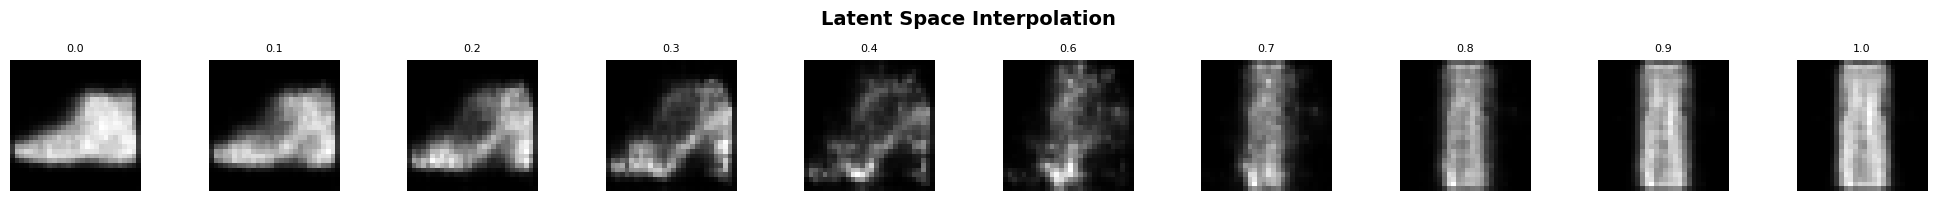


5. Generating training loss curves...
   ✓ Saved: vae_training_loss.png


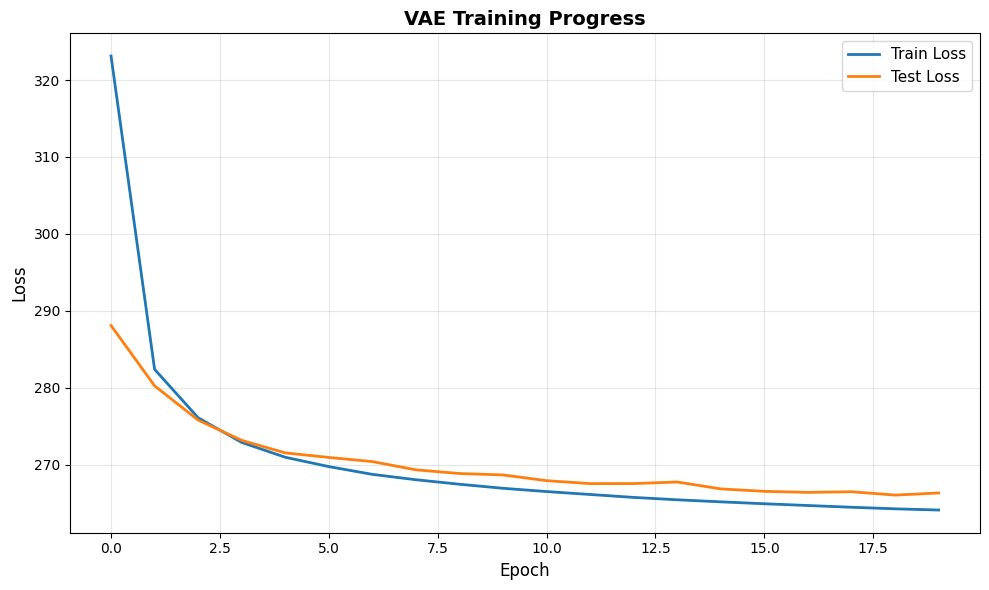


6. Generating latent space manifold...
   ✓ Saved: vae_manifold.png


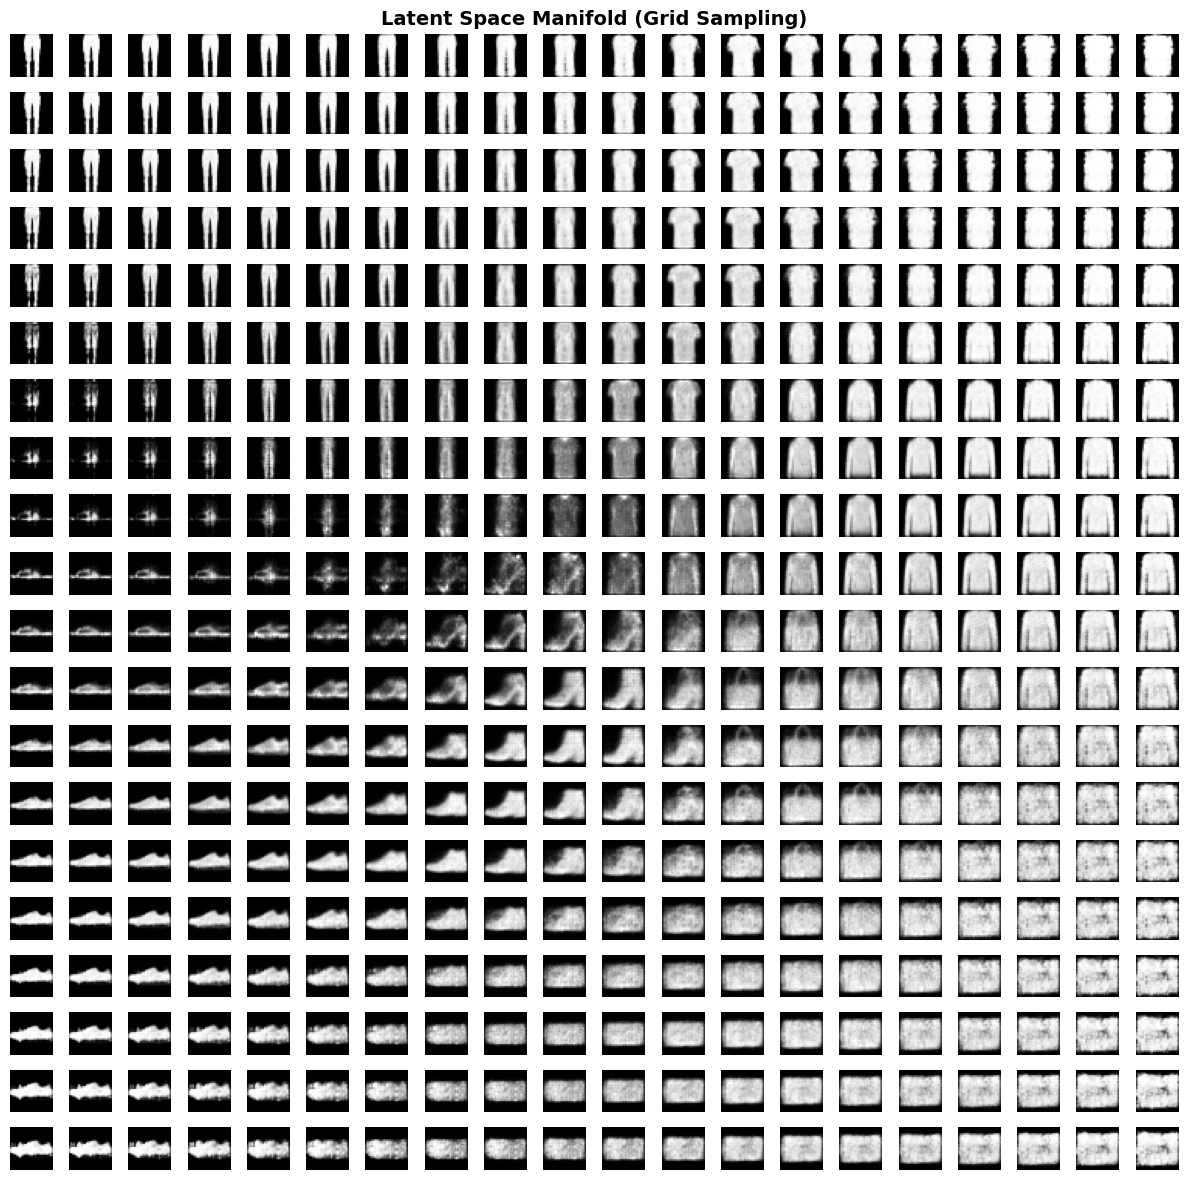


EXPERIMENT COMPLETE!

Generated files:
1. vae_reconstruction.png - Original vs Reconstructed images
2. vae_latent_space.png - Class-wise latent distributions
3. vae_generated_samples.png - Novel generated images
4. vae_interpolation.png - Smooth interpolation between images
5. vae_training_loss.png - Training progress
6. vae_manifold.png - Complete latent space exploration

Model summary:
- Latent dimensions: 2
- Final train loss: 264.1272
- Final test loss: 266.3425

Model saved as: vae_fashion_mnist.pth


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import struct
from pathlib import Path

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==================== DATA LOADING ====================
def read_idx_images(filename):
    """Read Fashion-MNIST IDX image files"""
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_idx_labels(filename):
    """Read Fashion-MNIST IDX label files"""
    with open(filename, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Load data
print("Loading Fashion-MNIST dataset...")
train_images = read_idx_images('train-images-idx3-ubyte')
train_labels = read_idx_labels('train-labels-idx1-ubyte')
test_images = read_idx_images('t10k-images-idx3-ubyte')
test_labels = read_idx_labels('t10k-labels-idx1-ubyte')

# Normalize to [0, 1]
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Convert to PyTorch tensors
train_images = torch.FloatTensor(train_images).unsqueeze(1)  # Add channel dimension
test_images = torch.FloatTensor(test_images).unsqueeze(1)
train_labels = torch.LongTensor(train_labels)
test_labels = torch.LongTensor(test_labels)

print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

# Create data loaders
batch_size = 128
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# ==================== VAE MODEL ====================
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten()
        )

        # Latent space parameters
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + sigma * epsilon"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 64, 7, 7)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# ==================== LOSS FUNCTION ====================
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction loss + KL divergence
    beta: weight for KL term (beta-VAE)
    """
    # Reconstruction loss (binary cross-entropy)
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss, recon_loss, kl_loss

# ==================== TRAINING ====================
def train_vae(model, train_loader, optimizer, epoch, beta=1.0):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon, mu, logvar = model(data)
        loss, recon_loss, kl_loss = vae_loss(recon, data, mu, logvar, beta)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] '
                  f'Loss: {loss.item() / len(data):.4f} '
                  f'Recon: {recon_loss.item() / len(data):.4f} '
                  f'KL: {kl_loss.item() / len(data):.4f}')

    return train_loss / len(train_loader.dataset)

def test_vae(model, test_loader, beta=1.0):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            loss, _, _ = vae_loss(recon, data, mu, logvar, beta)
            test_loss += loss.item()

    return test_loss / len(test_loader.dataset)

# ==================== MAIN TRAINING LOOP ====================
latent_dim = 2  # 2D for easy visualization
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
beta = 1.0  # Can increase for disentanglement

print("\nStarting training...")
train_losses = []
test_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_vae(model, train_loader, optimizer, epoch, beta)
    test_loss = test_vae(model, test_loader, beta)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'====> Epoch {epoch}: Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')

# ==================== VISUALIZATION ====================
model.eval()

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS...")
print("="*60)

# 1. Reconstruction comparison
print("\n1. Generating reconstructions...")
try:
    with torch.no_grad():
        sample_data, sample_labels = next(iter(test_loader))
        sample_data = sample_data[:8].to(device)
        recon, _, _ = model(sample_data)

        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            # Original
            axes[0, i].imshow(sample_data[i].cpu().squeeze(), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title('Original', fontsize=10)

            # Reconstruction
            axes[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed', fontsize=10)

        plt.tight_layout()
        plt.savefig('vae_reconstruction.png', dpi=150, bbox_inches='tight')
        print("   ✓ Saved: vae_reconstruction.png")
        plt.show()  # Display the plot
        plt.close()
except Exception as e:
    print(f"   ✗ Error: {e}")

# 2. Latent space visualization (class-wise)
print("\n2. Visualizing latent space...")
try:
    with torch.no_grad():
        latent_vectors = []
        labels_list = []

        for data, labels in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_vectors.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())

        latent_vectors = np.concatenate(latent_vectors, axis=0)
        labels_list = np.concatenate(labels_list, axis=0)

        plt.figure(figsize=(12, 10))
        colors = plt.cm.tab10(np.linspace(0, 1, 10))

        for i in range(10):
            mask = labels_list == i
            plt.scatter(latent_vectors[mask, 0], latent_vectors[mask, 1],
                       c=[colors[i]], label=class_names[i], alpha=0.6, s=10)

        plt.xlabel('Latent Dimension 1', fontsize=12)
        plt.ylabel('Latent Dimension 2', fontsize=12)
        plt.title('Class-wise Latent Space Representation', fontsize=14, fontweight='bold')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('vae_latent_space.png', dpi=150, bbox_inches='tight')
        print("   ✓ Saved: vae_latent_space.png")
        plt.show()
        plt.close()
except Exception as e:
    print(f"   ✗ Error: {e}")

# 3. Generate novel images by sampling latent space
print("\n3. Generating novel images...")
try:
    with torch.no_grad():
        # Sample from standard normal distribution
        n_samples = 20
        z = torch.randn(n_samples, latent_dim).to(device)
        generated = model.decode(z)

        fig, axes = plt.subplots(2, 10, figsize=(20, 4))
        for i in range(n_samples):
            row = i // 10
            col = i % 10
            axes[row, col].imshow(generated[i].cpu().squeeze(), cmap='gray')
            axes[row, col].axis('off')

        plt.suptitle('Generated Novel Images (Random Sampling)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('vae_generated_samples.png', dpi=150, bbox_inches='tight')
        print("   ✓ Saved: vae_generated_samples.png")
        plt.show()
        plt.close()
except Exception as e:
    print(f"   ✗ Error: {e}")

# 4. Latent space interpolation
print("\n4. Generating latent space interpolation...")
try:
    with torch.no_grad():
        # Get two random test samples
        idx1, idx2 = 0, 100
        img1 = test_images[idx1:idx1+1].to(device)
        img2 = test_images[idx2:idx2+1].to(device)

        # Encode
        mu1, _ = model.encode(img1)
        mu2, _ = model.encode(img2)

        # Interpolate
        n_interp = 10
        alphas = np.linspace(0, 1, n_interp)

        fig, axes = plt.subplots(1, n_interp, figsize=(20, 2))
        for i, alpha in enumerate(alphas):
            z_interp = (1 - alpha) * mu1 + alpha * mu2
            img_interp = model.decode(z_interp)
            axes[i].imshow(img_interp.cpu().squeeze(), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'{alpha:.1f}', fontsize=8)

        plt.suptitle('Latent Space Interpolation', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('vae_interpolation.png', dpi=150, bbox_inches='tight')
        print("   ✓ Saved: vae_interpolation.png")
        plt.show()
        plt.close()
except Exception as e:
    print(f"   ✗ Error: {e}")

# 5. Training loss curves
print("\n5. Generating training loss curves...")
try:
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(test_losses, label='Test Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('VAE Training Progress', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('vae_training_loss.png', dpi=150, bbox_inches='tight')
    print("   ✓ Saved: vae_training_loss.png")
    plt.show()
    plt.close()
except Exception as e:
    print(f"   ✗ Error: {e}")

# 6. Manifold visualization (grid sampling)
print("\n6. Generating latent space manifold...")
try:
    with torch.no_grad():
        n = 20
        grid_range = 3
        x = np.linspace(-grid_range, grid_range, n)
        y = np.linspace(-grid_range, grid_range, n)

        fig, axes = plt.subplots(n, n, figsize=(12, 12))
        for i, yi in enumerate(y):
            for j, xi in enumerate(x):
                z = torch.FloatTensor([[xi, yi]]).to(device)
                img = model.decode(z)
                axes[i, j].imshow(img.cpu().squeeze(), cmap='gray')
                axes[i, j].axis('off')

        plt.suptitle('Latent Space Manifold (Grid Sampling)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('vae_manifold.png', dpi=150, bbox_inches='tight')
        print("   ✓ Saved: vae_manifold.png")
        plt.show()
        plt.close()
except Exception as e:
    print(f"   ✗ Error: {e}")

print("\n" + "="*60)
print("EXPERIMENT COMPLETE!")
print("="*60)
print("\nGenerated files:")
print("1. vae_reconstruction.png - Original vs Reconstructed images")
print("2. vae_latent_space.png - Class-wise latent distributions")
print("3. vae_generated_samples.png - Novel generated images")
print("4. vae_interpolation.png - Smooth interpolation between images")
print("5. vae_training_loss.png - Training progress")
print("6. vae_manifold.png - Complete latent space exploration")
print("\nModel summary:")
print(f"- Latent dimensions: {latent_dim}")
print(f"- Final train loss: {train_losses[-1]:.4f}")
print(f"- Final test loss: {test_losses[-1]:.4f}")
print("="*60)

# Save model
torch.save(model.state_dict(), 'vae_fashion_mnist.pth')
print("\nModel saved as: vae_fashion_mnist.pth")